In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error

In [53]:
dataset = pd.read_csv('datasets/final_dataset.csv')

In [54]:

# Data Preparation
# Melting the dataset so that each row represents a single date and a single page
melted_dataset = dataset.melt(id_vars=['Page'], var_name='Date', value_name='Traffic')

# Converting 'Date' to datetime format
melted_dataset['Date'] = pd.to_datetime(melted_dataset['Date'])

# Sorting the dataset by 'Page' and 'Date'
melted_dataset.sort_values(by=['Page', 'Date'], inplace=True)

# Feature Engineering

# Extracting seasonality features
melted_dataset['DayOfWeek'] = melted_dataset['Date'].dt.dayofweek
melted_dataset['WeekOfYear'] = melted_dataset['Date'].dt.isocalendar().week
melted_dataset['Month'] = melted_dataset['Date'].dt.month

# Creating lag features for the previous 7 days
for lag in range(1, 8):
    melted_dataset[f'Lag_{lag}'] = melted_dataset.groupby('Page')['Traffic'].shift(lag)

# Rolling statistics - window of 7 days
melted_dataset['Rolling_Mean'] = melted_dataset.groupby('Page')['Traffic'].transform(lambda x: x.rolling(window=7).mean())
melted_dataset['Rolling_Median'] = melted_dataset.groupby('Page')['Traffic'].transform(lambda x: x.rolling(window=7).median())

# Dropping NaN values created by lag and rolling features
melted_dataset.dropna(inplace=True)


# Splitting the dataset into training and test sets
# train_set, test_set = train_test_split(melted_dataset, test_size=0.2, shuffle=False)

min_date = melted_dataset['Date'].min()
max_date = melted_dataset['Date'].max()

# Calculate the date range
date_range = max_date - min_date

# Determine the cutoff date (80% of the time period)
cutoff_date = min_date + pd.to_timedelta(0.8 * date_range)

# Split into training and test sets
train_set = melted_dataset[melted_dataset['Date'] < cutoff_date]
test_set = melted_dataset[melted_dataset['Date'] >= cutoff_date]

# Displaying the transformed dataset
melted_dataset.head()

,Page,Date,Traffic,DayOfWeek,WeekOfYear,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Rolling_Mean,Rolling_Median
18626,1._April_de.wikipedia.org_desktop_all-agents,2015-07-08,46.0,2,28,7,41.0,44.0,40.0,39.0,41.0,33.0,51.0,40.571429,41.0
20991,1._April_de.wikipedia.org_desktop_all-agents,2015-07-09,21.0,3,28,7,46.0,41.0,44.0,40.0,39.0,41.0,33.0,38.857143,41.0
23356,1._April_de.wikipedia.org_desktop_all-agents,2015-07-10,29.0,4,28,7,21.0,46.0,41.0,44.0,40.0,39.0,41.0,37.142857,40.0
25721,1._April_de.wikipedia.org_desktop_all-agents,2015-07-11,34.0,5,28,7,29.0,21.0,46.0,41.0,44.0,40.0,39.0,36.428571,40.0
28086,1._April_de.wikipedia.org_desktop_all-agents,2015-07-12,39.0,6,28,7,34.0,29.0,21.0,46.0,41.0,44.0,40.0,36.285714,39.0


In [55]:
# increase the amount of iterations
X_training = train_set.drop(columns=['Page', 'Date', 'Traffic'])
X_test = test_set.drop(columns=['Page', 'Date', 'Traffic'])
y_training = train_set['Traffic']
y_test = test_set['Traffic']

In [56]:
huber = HuberRegressor().fit(X_training, y_training)

/home/tibe/PycharmProjects/DM_WebTraffic/venv/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [47]:
huber_predictions = huber.predict(X_test)

In [48]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

In [49]:
# get smape score of huber_predictions
mean_absolute_error_score = mean_absolute_error(y_test, huber_predictions)
smape_score = smape(y_test, huber_predictions)
smape_score

0.4771598169293364

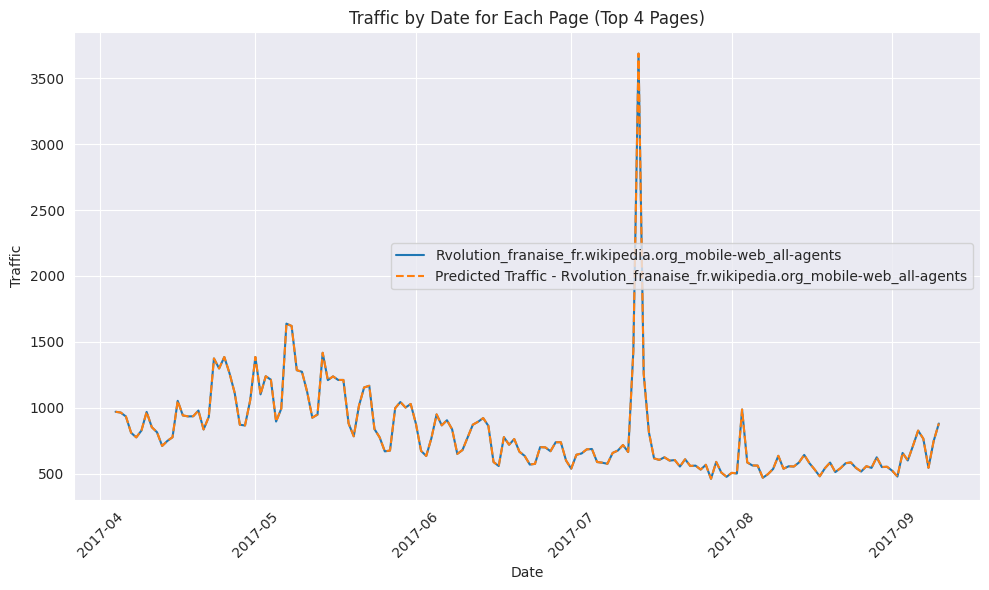

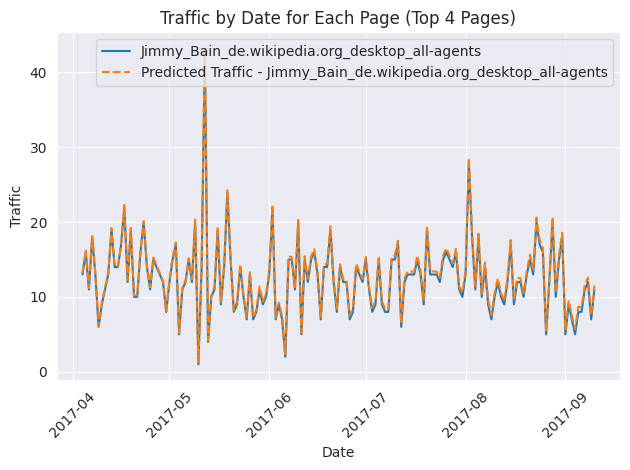

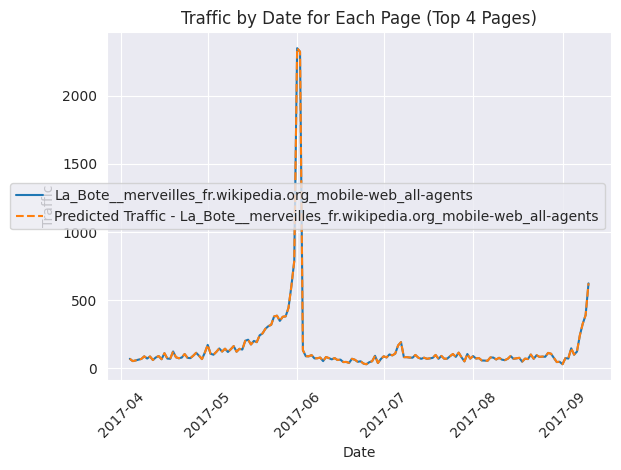

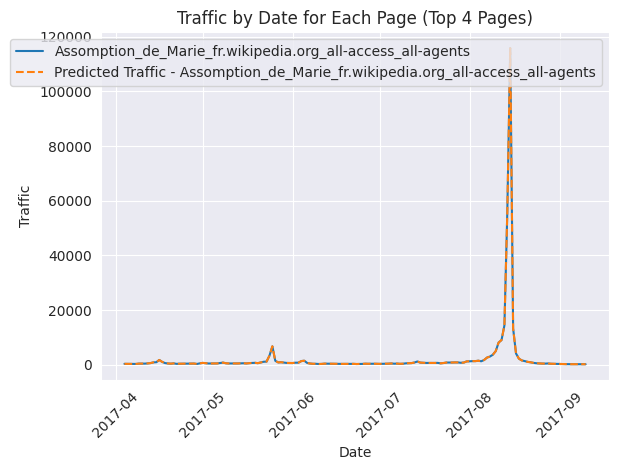

In [51]:
plt.figure(figsize=(10, 6))

# make a copy of the test_set to make sure not to modify it
plot_set = test_set.copy()

plot_set['Predicted_Traffic'] = huber_predictions

# Select the first 4 unique pages
unique_pages = plot_set['Page'].unique()
# Select a random unique page
for _ in range(4):
    random_page = np.random.choice(plot_set['Page'].unique())
    
    # Filter the DataFrame to only include the randomly selected page
    filtered_df = plot_set[plot_set['Page'] == random_page]
    
    # Then plot using this filtered DataFrame
    for name, group in filtered_df.groupby('Page'):
        # filter out russian letters out of name
        safe_page_name = ''.join([char for char in random_page if ord(char) < 128])
        plt.plot(group['Date'], group['Traffic'], label=safe_page_name)
        plt.plot(group['Date'], group['Predicted_Traffic'], linestyle='--', label=f'Predicted Traffic - {safe_page_name}')
        plt.xlabel('Date')
        plt.ylabel('Traffic')
        plt.title('Traffic by Date for Each Page (Randomly Selected)')
        plt.legend()
        plt.xticks(rotation=45)  # Rotate date labels for better readability
        plt.tight_layout()
        plt.show()